<a href="https://colab.research.google.com/github/SumiranRai/MDSC-Lab/blob/main/MDSC-201-Statistical-Methods-Using-R/R_Assignment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

R Programming Assignment VII

By Sumiran Rai

Roll No. - 24040208007

# Diabetes Prediction Using Logistic Regression in R


### For Generating PDF

In [2]:
install.packages("tinytex")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### Installing necessary libraries

In [3]:
install.packages("caret", dependencies=TRUE)
install.packages("mlbench")  # Needed for PIMA dataset
install.packages("pROC")     # Needed for ROC Curve
install.packages("ggplot2")  # For visualization

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘rbibutils’, ‘future’, ‘globals’, ‘R.methodsS3’, ‘R.oo’, ‘R.utils’, ‘bitops’, ‘Rdpack’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘R.cache’, ‘caTools’, ‘TH.data’, ‘profileModel’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘RcppEigen’, ‘lazyeval’, ‘plotrix’, ‘diagram’, ‘lava’, ‘styler’, ‘classInt’, ‘labelled’, ‘gplots’, ‘libcoin’, ‘matrixStats’, ‘multcomp’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘sparsevctrs’, ‘timeDate’, ‘brglm’, ‘gtools’, ‘lme4’, ‘qvcalc’, ‘rex’, ‘Formula’, ‘plotmo’, ‘prodlim’, ‘combinat’, ‘questionr’, ‘ROCR’, ‘mvtnorm’, ‘modeltools’, ‘strucchange’, ‘coin’, ‘zoo’, ‘sandwich’, ‘ROSE’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’, ‘BradleyTerry2’, ‘covr’, ‘Cubist’, ‘earth’, ‘ellipse’, ‘fastICA’, ‘gam’, ‘ipred’, ‘kernlab’, ‘klaR’, ‘mda’, ‘mlbench’, ‘MLmetrics’, ‘pamr’, ‘party’, ‘pls’, ‘proxy’

In [4]:
install.packages("dplyr")
install.packages("tidyr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### Binary Classification

In this type of classification, the dataset consists of two classes. Thus, the labels are often defined as 0
 and 1
, or −1
 and 1
. The input data can be images, text, points etc. As the name suggests, linear classifiers classify data into labels based on a linear combination of input features. Therefore, these classifiers separate data using a line or plane or a hyperplane (a plane in more than 2 dimensions). They can only be used to classify data that is linearly separable. We first use a toy dataset to show the effects of linear classification.


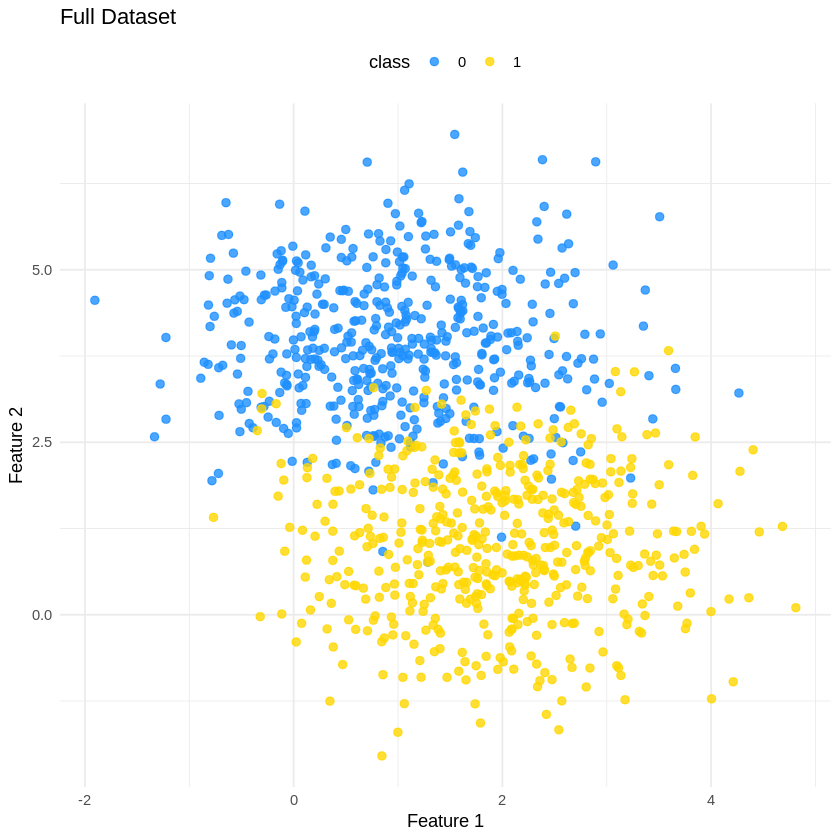

In [5]:
# Load necessary library
library(ggplot2)

# ==================================================
# 1) Generate dummy two-class data
#    (Similar to make_blobs in Python)
# ==================================================
set.seed(0)

# Number of points per class
n_class <- 500

# Simulate class 0 around (1, 4)
x1_class0 <- rnorm(n_class, mean = 1, sd = 1)
x2_class0 <- rnorm(n_class, mean = 4, sd = 1)

# Simulate class 1 around (2, 1)
x1_class1 <- rnorm(n_class, mean = 2, sd = 1)
x2_class1 <- rnorm(n_class, mean = 1, sd = 1)

# Combine into one dataset
df <- data.frame(
  x1    = c(x1_class0, x1_class1),
  x2    = c(x2_class0, x2_class1),
  class = factor(c(rep(0, n_class), rep(1, n_class)))  # binary classes
)

# ==================================================
# 2) Plot the full dataset using similar colors
# ==================================================
ggplot(df, aes(x = x1, y = x2, color = class)) +
  geom_point(alpha = 0.8, size = 2) +
  scale_color_manual(values = c("#1E90FF", "#FFD700")) +  # Dark Purple & Yellow
  theme_minimal() +
  labs(title = "Full Dataset", x = "Feature 1", y = "Feature 2") +
  theme(legend.position = "top")

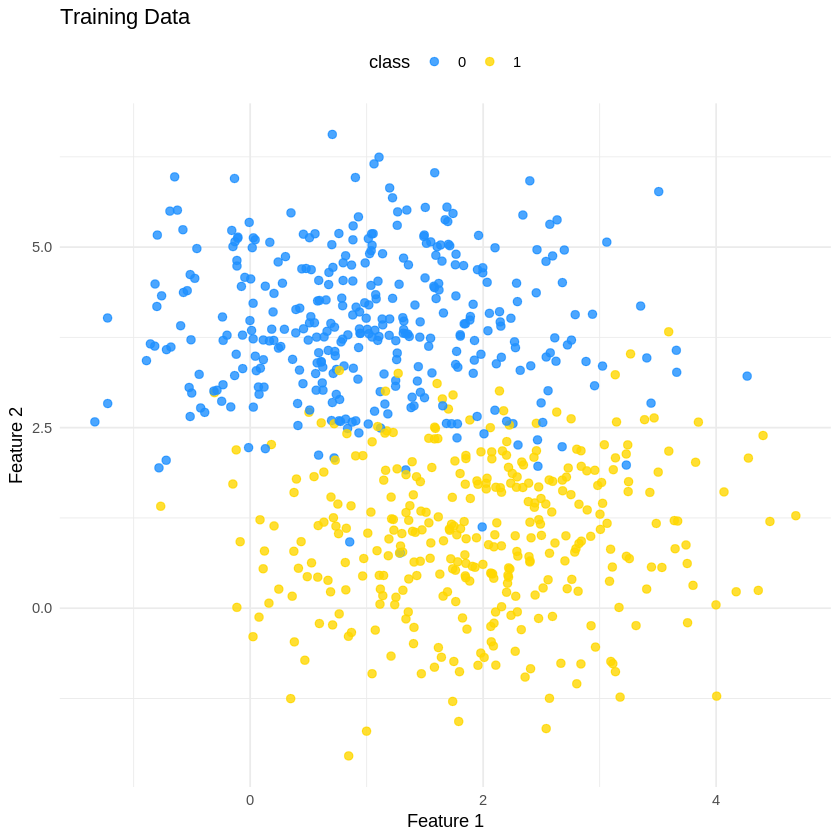

In [6]:
# ==================================================
# 3) Split into train/test
# ==================================================
set.seed(123)  # for reproducibility
train_indices <- sample(seq_len(nrow(df)), size = 0.7 * nrow(df))

train_df <- df[train_indices, ]
test_df  <- df[-train_indices, ]

# ==================================================
# 4) Plot train and test data separately
# ==================================================

# Training set
ggplot(train_df, aes(x = x1, y = x2, color = class)) +
  geom_point(alpha = 0.8, size = 2) +
  scale_color_manual(values = c("#1E90FF", "#FFD700")) +
  theme_minimal() +
  labs(title = "Training Data", x = "Feature 1", y = "Feature 2") +
  theme(legend.position = "top")


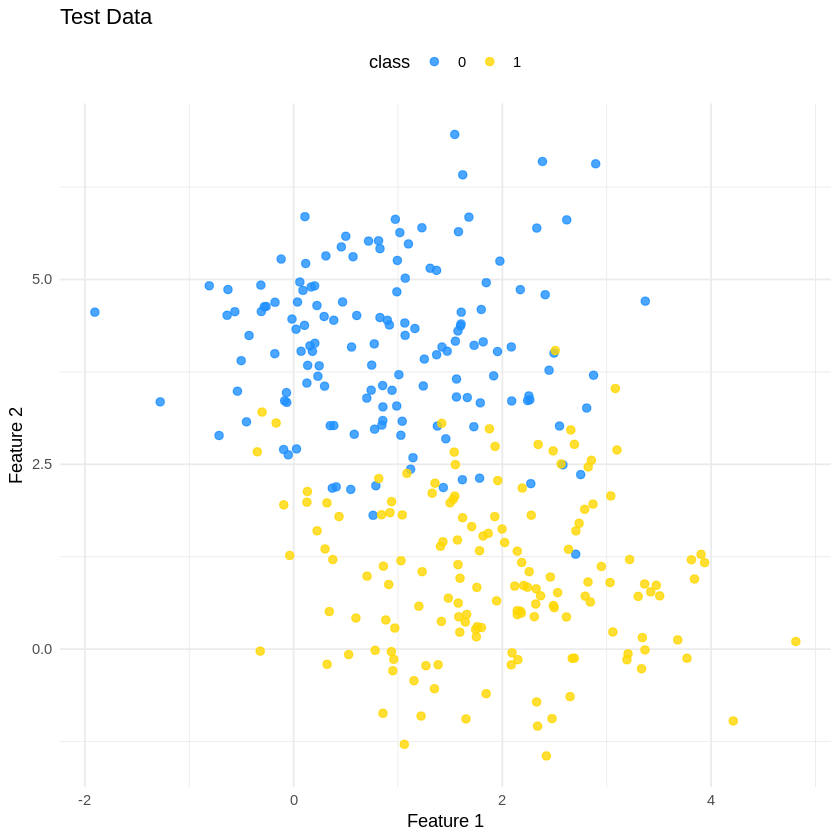

In [7]:
# Test set
ggplot(test_df, aes(x = x1, y = x2, color = class)) +
  geom_point(alpha = 0.8, size = 2) +
  scale_color_manual(values = c("#1E90FF", "#FFD700")) +
  theme_minimal() +
  labs(title = "Test Data", x = "Feature 1", y = "Feature 2") +
  theme(legend.position = "top")

### Load the required Packages

In [21]:
# Load necessary libraries
library(caret)
library(pROC)
library(ggplot2)
library(dplyr)
library(tidyr)

# Load the PIMA dataset
data(PimaIndiansDiabetes, package = "mlbench")

# Diabetes Dataset

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

## History of Pima Indians

Pima are descendants of people that inhabited the Sonoran Desert and Sierra Madre areas for centuries. Around 300 B.C., they moved to the Gila River Valley, which was then in Mexico but later became part of the United States in 1853. A Pima reservation was created in Arizona in 1959. They adapted to their desert homeland by directing water to support subsistence agriculture.

Around 1900, the number of white settlers increased, leading to a diversion of water resources. This impacted the Pima people’s food intake and way of life. They transitioned from a labor-intensive farming lifestyle to one with little physical activity and a diet high in fat. As a consequence, the prevalence of type 2 diabetes (T2DM) among Arizona Pimas became the highest recorded for any geographically defined population (Schulz et al., 2015).

The Pima population has been under study by the National Institute of Diabetes and Digestive and Kidney Diseases at intervals of two years since 1965. Since epidemiological evidence indicates that T2DM results from the interaction of genetic and environmental factors, the Pima Indians Diabetes Dataset includes attributes that are related to the onset of diabetes and its future complications.

## Reference

Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In *Proceedings of the Symposium on Computer Applications and Medical Care* (pp. 261–265). IEEE Computer Society Press.

## Attributes (Columns)

- **Pregnancies**: Number of times pregnant  
- **Glucose**: Plasma glucose concentration (mg/dL) measured 2 hours into an oral glucose tolerance test  
- **BloodPressure**: Diastolic blood pressure (mm Hg)  
- **SkinThickness**: Triceps skin fold thickness (mm)  
- **Insulin**: 2-hour serum insulin (μU/mL)  
- **BMI**: Body mass index (weight in kg/(height in m)²)  
- **DiabetesPedigreeFunction**: Diabetes pedigree function (a measure of genetic influence)  
- **Age**: Age (years)  
- **Outcome**: Class variable (0 = No diabetes, 1 = Diabetes)


In [22]:
# Get the number of records (rows)
num_records <- nrow(PimaIndiansDiabetes)

# Print the number of records
print(num_records)

[1] 768


In [23]:
table(PimaIndiansDiabetes$diabetes)


neg pos 
500 268 

In [24]:
# Get summary statistics (equivalent to data.describe() in Python)
summary(PimaIndiansDiabetes)

    pregnant         glucose         pressure         triceps     
 Min.   : 0.000   Min.   :  0.0   Min.   :  0.00   Min.   : 0.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.: 0.00  
 Median : 3.000   Median :117.0   Median : 72.00   Median :23.00  
 Mean   : 3.845   Mean   :120.9   Mean   : 69.11   Mean   :20.54  
 3rd Qu.: 6.000   3rd Qu.:140.2   3rd Qu.: 80.00   3rd Qu.:32.00  
 Max.   :17.000   Max.   :199.0   Max.   :122.00   Max.   :99.00  
    insulin           mass          pedigree           age        diabetes 
 Min.   :  0.0   Min.   : 0.00   Min.   :0.0780   Min.   :21.00   neg:500  
 1st Qu.:  0.0   1st Qu.:27.30   1st Qu.:0.2437   1st Qu.:24.00   pos:268  
 Median : 30.5   Median :32.00   Median :0.3725   Median :29.00            
 Mean   : 79.8   Mean   :31.99   Mean   :0.4719   Mean   :33.24            
 3rd Qu.:127.2   3rd Qu.:36.60   3rd Qu.:0.6262   3rd Qu.:41.00            
 Max.   :846.0   Max.   :67.10   Max.   :2.4200   Max.   :81.00            

### Proportions

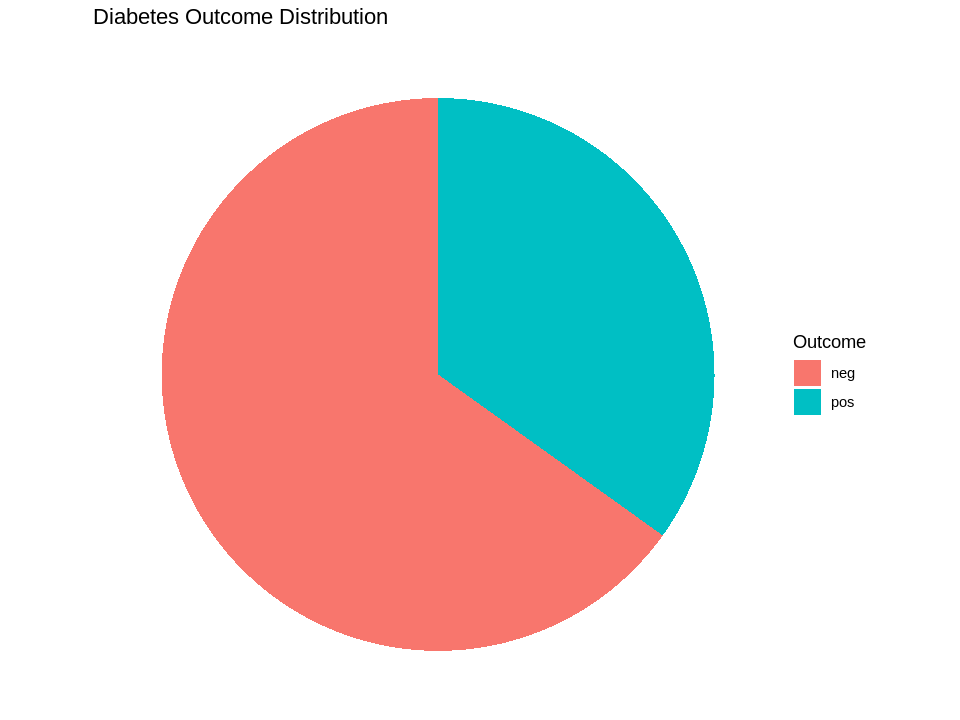

In [25]:
# Compute proportions of outcome values (Diabetes vs No Diabetes)
target <- prop.table(table(PimaIndiansDiabetes$diabetes))

# Convert to a dataframe for visualization
target_df <- as.data.frame(target)
colnames(target_df) <- c("Outcome", "Proportion")

# Plot the pie chart
ggplot(target_df, aes(x = "", y = Proportion, fill = Outcome)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y", start = 0) +
  theme_void() +
  ggtitle("Diabetes Outcome Distribution")

# Data Visualization

### Distribution Plots

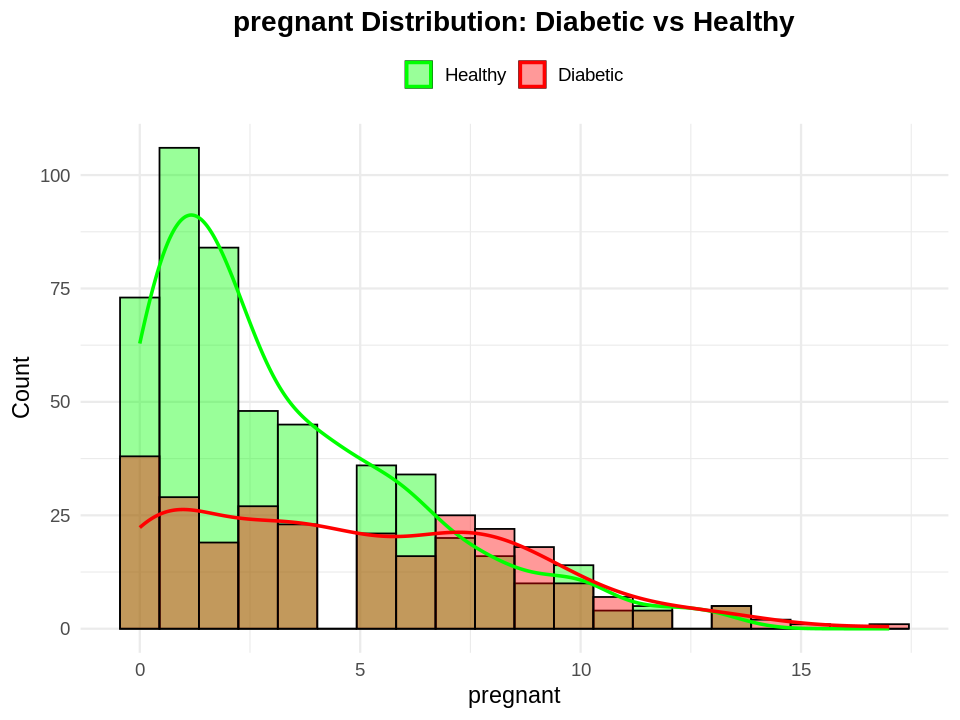

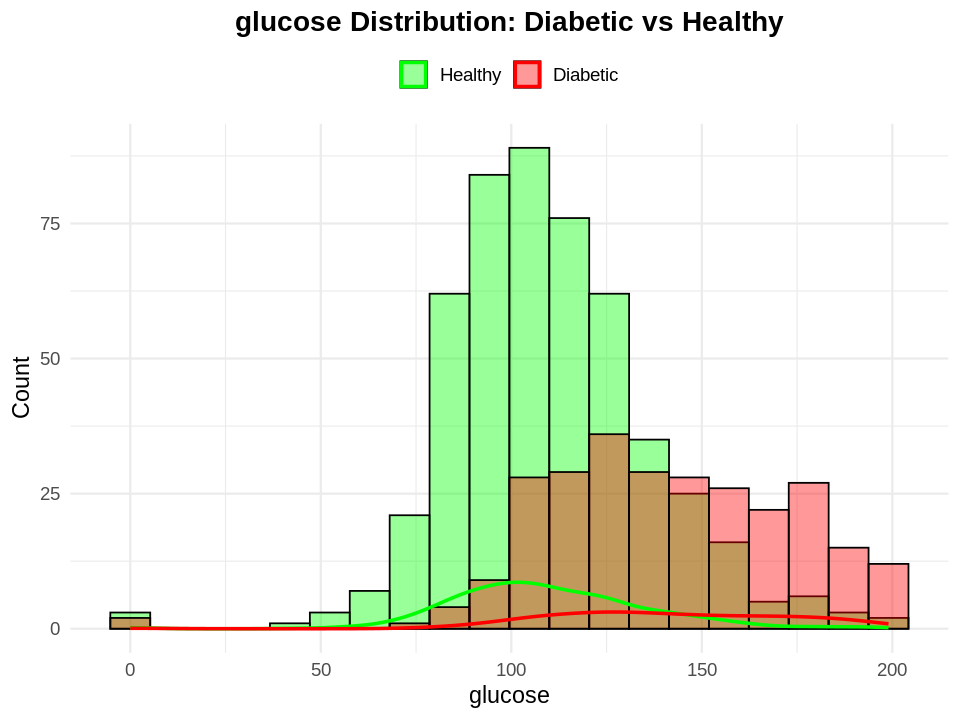

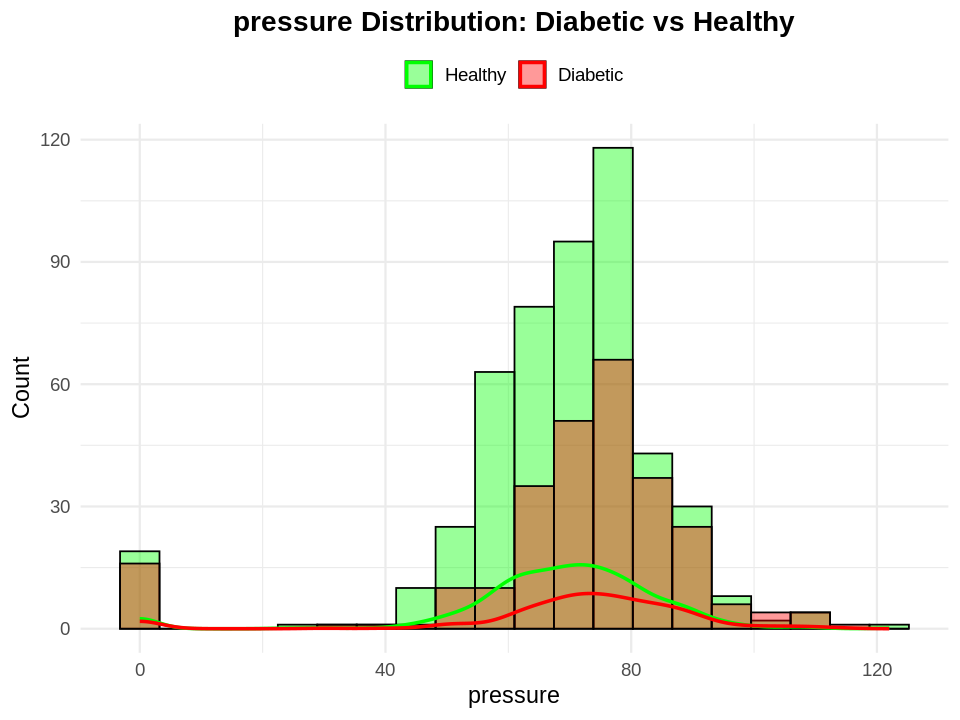

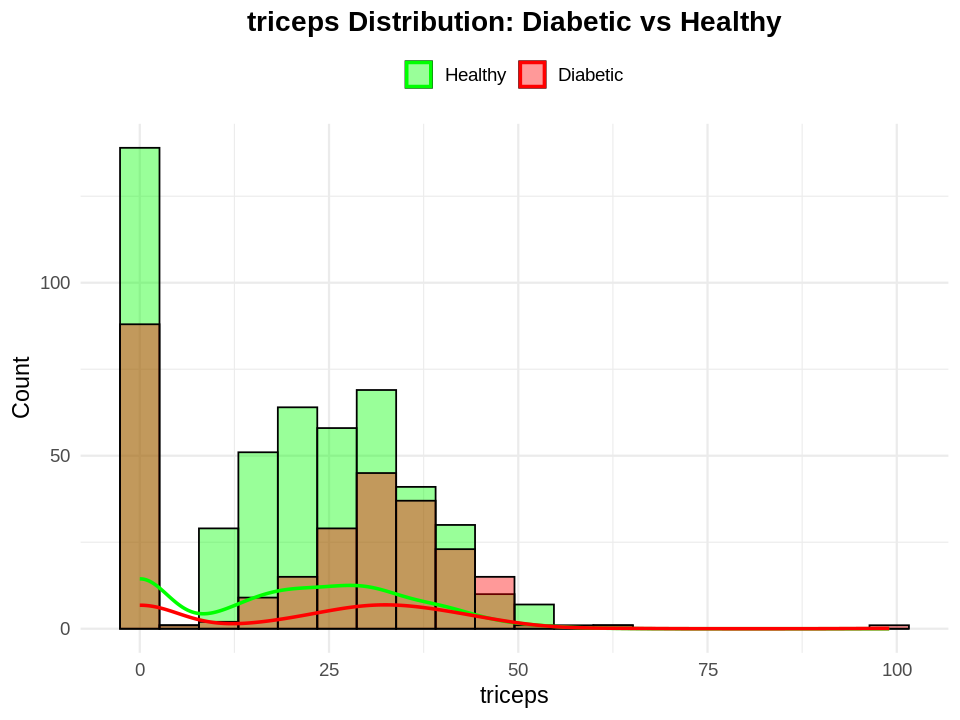

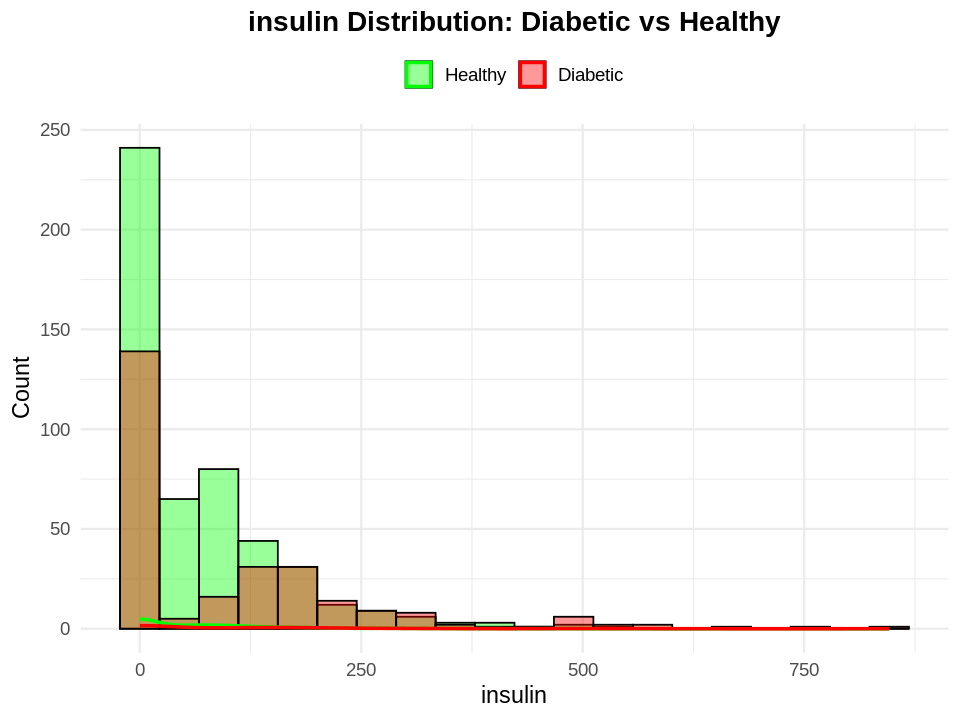

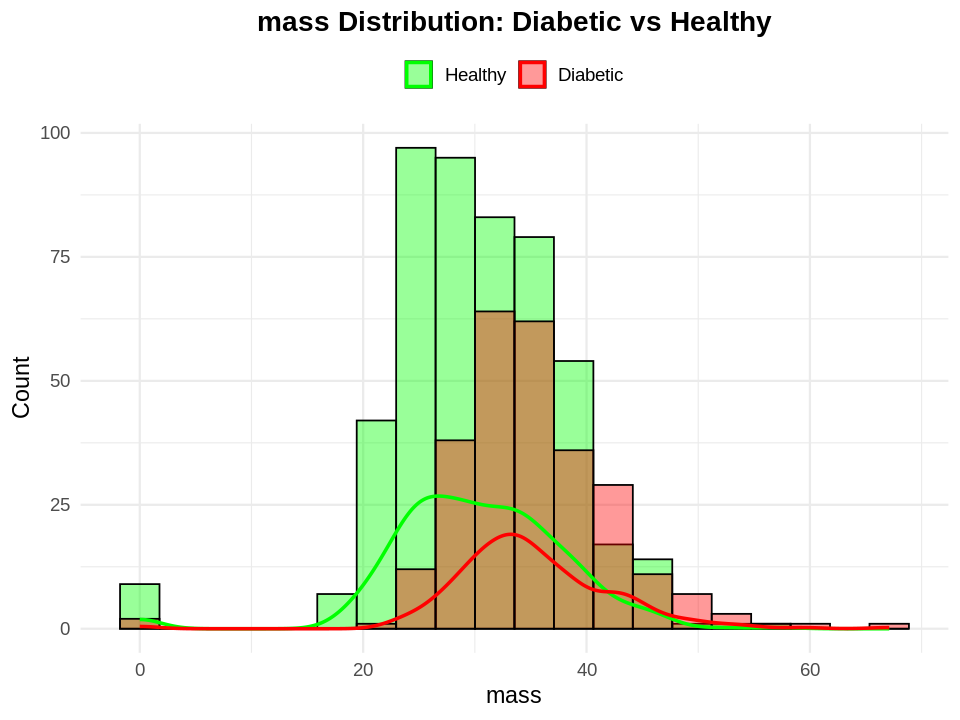

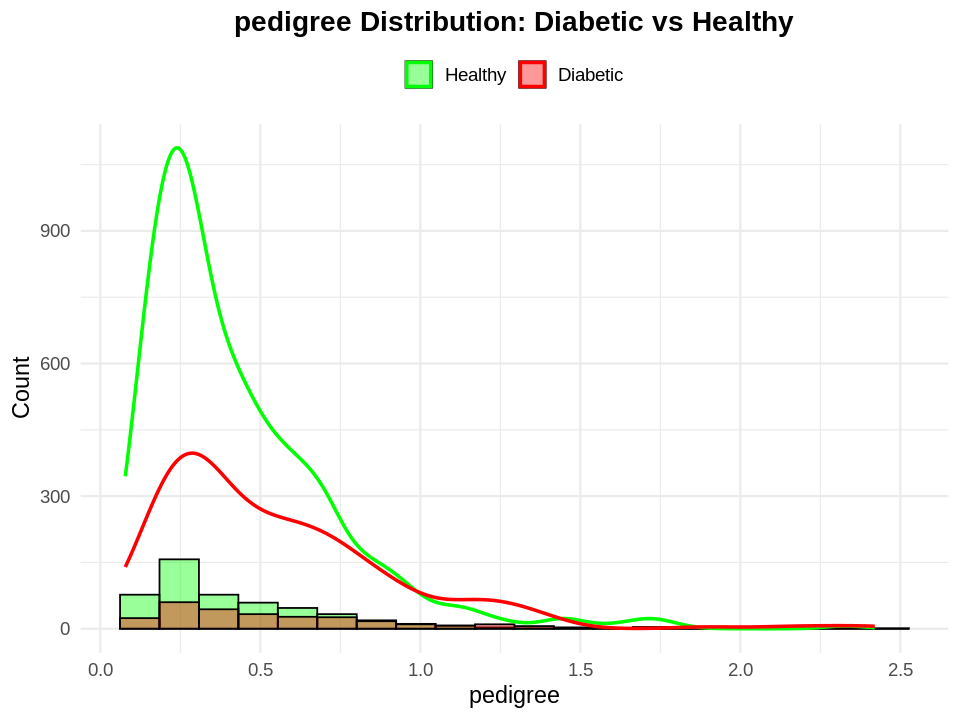

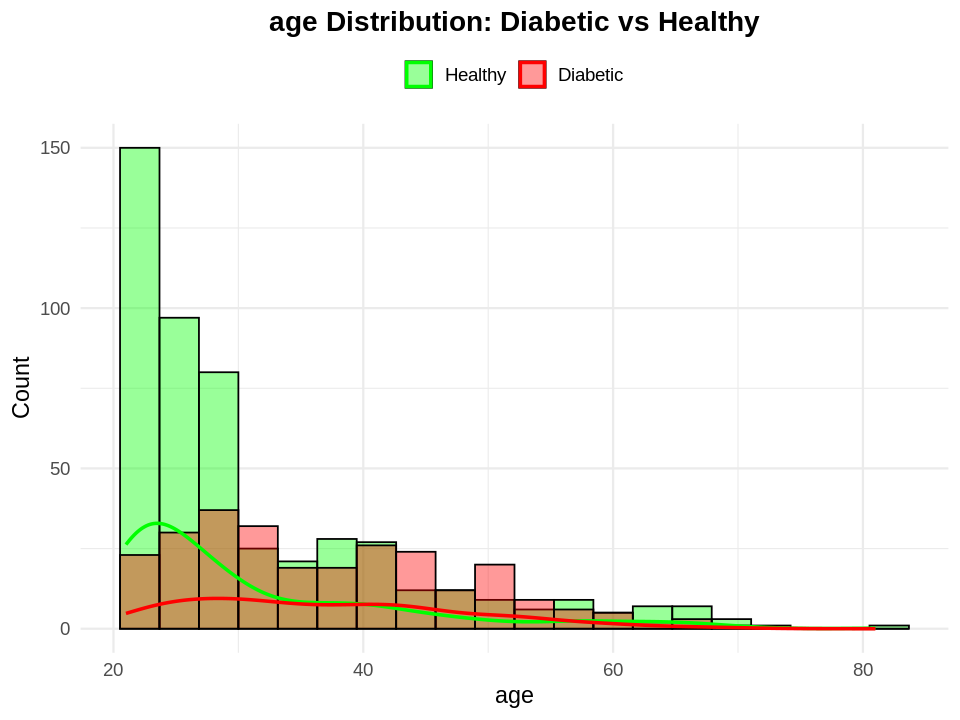

In [26]:
# Convert Outcome to a factor for visualization
PimaIndiansDiabetes$diabetes <- factor(PimaIndiansDiabetes$diabetes,
                                       levels = c("neg", "pos"),
                                       labels = c("Healthy", "Diabetic"))

# Load required library
library(ggplot2)

# Modified function for better visualization
compare_dist_by_target <- function(features, data) {
  for (feature in features) {
    # Create histogram with density overlay
    p <- ggplot(data, aes(x = .data[[feature]], fill = diabetes, color = diabetes)) +
      geom_histogram(aes(y = ..count..), alpha = 0.4, bins = 20, position = "identity", color = "black") +
      geom_density(aes(y = ..count..), size = 1, fill = NA) +
      scale_fill_manual(values = c("Healthy" = "green", "Diabetic" = "red")) +  # Matching colors
      scale_color_manual(values = c("Healthy" = "green", "Diabetic" = "red")) +  # KDE curve colors
      labs(title = paste(feature, "Distribution: Diabetic vs Healthy"),
           x = feature, y = "Count") +
      theme_minimal(base_size = 14) +
      theme(legend.position = "top",
            legend.title = element_blank(),
            plot.title = element_text(hjust = 0.5, face = "bold"))

    # Print the plot
    print(p)
  }
}

# Increase plot size
options(repr.plot.width = 8, repr.plot.height = 6)

# Get all feature names excluding 'diabetes' (Outcome)
features <- setdiff(names(PimaIndiansDiabetes), "diabetes")

# Call the function for visualization
compare_dist_by_target(features, PimaIndiansDiabetes)

### Are there and missing values?

In [27]:
# python - data.isna().sum()
# Check for missing values in each column
colSums(is.na(PimaIndiansDiabetes))

pregnant  glucose pressure  triceps  insulin     mass pedigree      age 
       0        0        0        0        0        0        0        0 
diabetes 
       0

### Logistic Regression

Logistic regression is named for the function used at the core of the method, the logistic function.

The logistic function, more popularly called the sigmoid function was to describe properties of population growth in ecology, rising quickly and maxing out at the carrying capacity of the environment.

It’s an S-shaped curve that can take any real-valued number and map it into a value between 0 and 1, but never exactly at those limits.

1/(1+e−value)

Where e
 is the base of the natural logarithms and value is the actual numerical value that you want to transform. Below is a plot of the numbers between −5
 and 5
 transformed into the range 0
 and 1
 using the logistic function.

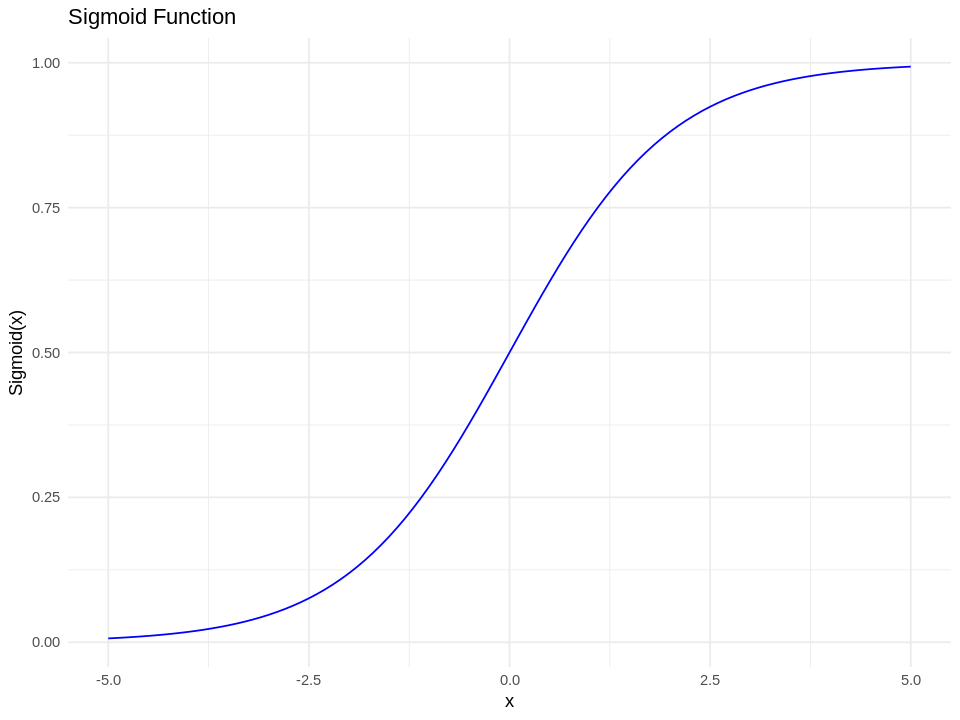

In [29]:
# Load necessary library
library(ggplot2)

# Defining the sigmoid function
sigmoid <- function(x) {
  return (1 / (1 + exp(-x)))
}

# Generate inputs from -5 to 5
x <- seq(-5, 5, by = 0.1)

# Apply the sigmoid function
sig <- sigmoid(x)

# Create a data frame for plotting
df <- data.frame(x = x, sigmoid = sig)

# Plot using ggplot2
ggplot(df, aes(x = x, y = sigmoid)) +
  geom_line(color = "blue") +
  ggtitle("Sigmoid Function") +
  xlab("x") +
  ylab("Sigmoid(x)") +
  theme_minimal()

In [30]:
# Display the first 6 rows of the dataset (default)
head(PimaIndiansDiabetes)

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,6,148,72,35,0,33.6,0.627,50,Diabetic
2,1,85,66,29,0,26.6,0.351,31,Healthy
3,8,183,64,0,0,23.3,0.672,32,Diabetic
4,1,89,66,23,94,28.1,0.167,21,Healthy
5,0,137,40,35,168,43.1,2.288,33,Diabetic
6,5,116,74,0,0,25.6,0.201,30,Healthy


### Correlation Plot

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



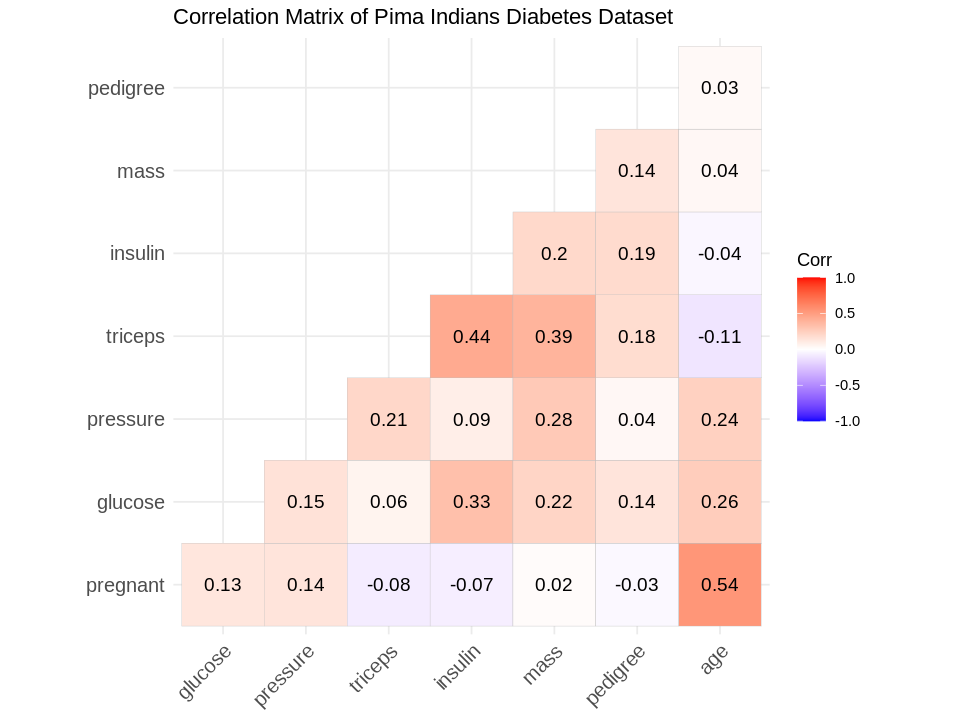

In [32]:
# install.packages("ggplot2")
install.packages("ggcorrplot")
library(ggplot2)
library(ggcorrplot)

# Compute correlation matrix
cor_matrix <- cor(PimaIndiansDiabetes[, sapply(PimaIndiansDiabetes, is.numeric)], use = "complete.obs")

# Create a professional-looking heatmap (Lower Triangle)
ggcorrplot(cor_matrix, method = "square", type = "lower",
           colors = c("blue", "white", "red"),  # Blue for negative, red for positive
           lab = TRUE,  # Show correlation values
           lab_size = 4,  # Increase text size
           title = "Correlation Matrix of Pima Indians Diabetes Dataset",
           ggtheme = theme_minimal())

### Best practice - For Senior Management

In [33]:
############################# Best practice - For Senior management
library(ggplot2)
library(reshape2)


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




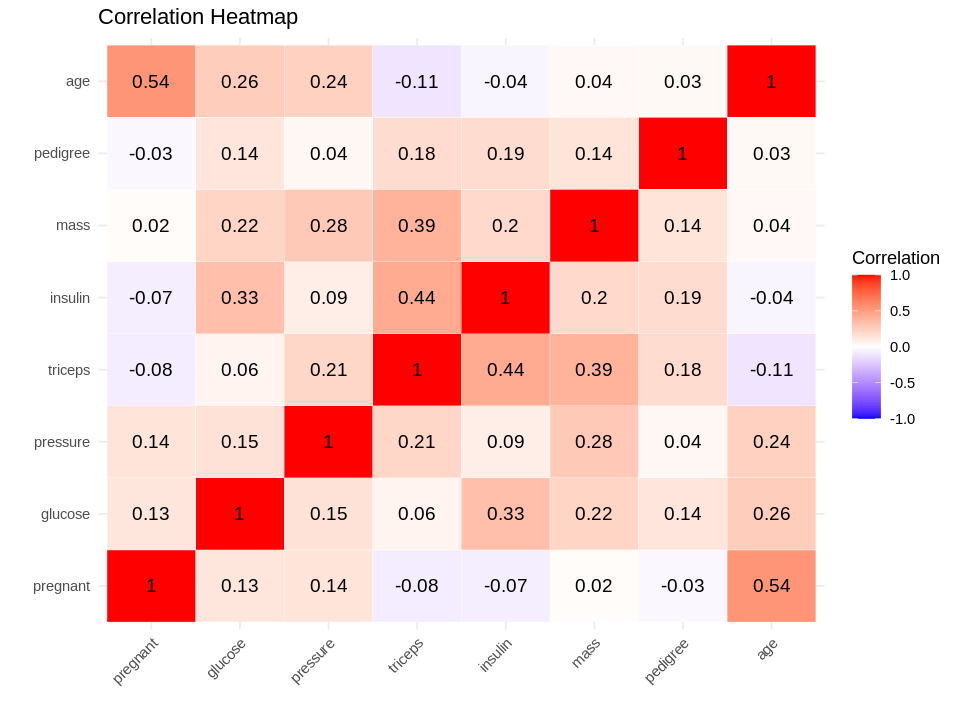

In [34]:
# Compute correlation matrix
cor_matrix <- cor(PimaIndiansDiabetes[, sapply(PimaIndiansDiabetes, is.numeric)], use = "complete.obs")

# Convert matrix to long format
cor_long <- melt(cor_matrix)

# Heatmap with professional styling
ggplot(cor_long, aes(Var1, Var2, fill = value)) +
  geom_tile(color = "white") +  # White gridlines for better separation
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0,
                       limit = c(-1,1), space = "Lab", name="Correlation") +
  geom_text(aes(label = round(value, 2)), color = "black", size = 4) +  # Add text labels
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
  labs(title = "Correlation Heatmap", x = "", y = "")

In [35]:
trainIndex <- createDataPartition(PimaIndiansDiabetes$diabetes, p = 0.7, list = FALSE)
trainData <- PimaIndiansDiabetes[trainIndex, ]
testData <- PimaIndiansDiabetes[-trainIndex, ]

# Check class distribution in train and test
table(trainData$diabetes)


 Healthy Diabetic 
     350      188 

In [36]:
table(testData$diabetes)


 Healthy Diabetic 
     150       80 

In [37]:
dim(trainData)  # Check training data dimensions

[1] 538   9

In [38]:
dim(testData)   # Check testing data dimensions

[1] 230   9

### Train a logistic regression model

In [39]:
logit_model <- glm(diabetes ~ ., data = trainData, family = binomial)
predictions <- predict(logit_model, testData, type = "response")  # Get probabilities
pred_class <- ifelse(predictions > 0.5, "Diabetic", "Healthy")  # Convert probabilities to class labels

table(pred_class)  # Check if all predictions are same

pred_class
Diabetic  Healthy 
      64      166 

In [40]:
table(testData$diabetes, pred_class)

          pred_class
           Diabetic Healthy
  Healthy        13     137
  Diabetic       51      29

In [41]:
table(trainData$diabetes)


 Healthy Diabetic 
     350      188 

### Build the model

In [42]:
##########################################
# Train a logistic regression model
logit_model <- glm(diabetes ~ ., data = trainData, family = binomial)
table(trainData$diabetes)


 Healthy Diabetic 
     350      188 

In [43]:
###############################################
# Predict on test data
pred_prob <- predict(logit_model, testData, type = "response")
# pred_class <- ifelse(pred_prob > 0.5, "pos", "neg")
# pred_class <- ifelse(predictions > 0.5, "Diabetic","Healthy")
pred_class <- ifelse(pred_prob > 0.5, "Diabetic", "Healthy")
pred_class <- factor(pred_class, levels = c("Healthy", "Diabetic"))

# Convert predictions and actual values into factors for confusion matrix
#pred_class <- factor(pred_class, levels = c("neg", "pos"))
# pred_class <- factor(pred_class, levels = c("Healthy", "Diabetic"))
#actual_class <- factor(testData$diabetes, levels = c("neg", "pos"))
actual_class <- factor(testData$diabetes, levels = c("Healthy", "Diabetic"))

# Generate a confusion matrix
conf_matrix <- confusionMatrix(pred_class, actual_class)
print(conf_matrix)

Confusion Matrix and Statistics

          Reference
Prediction Healthy Diabetic
  Healthy      137       29
  Diabetic      13       51
                                          
               Accuracy : 0.8174          
                 95% CI : (0.7613, 0.8651)
    No Information Rate : 0.6522          
    P-Value [Acc > NIR] : 2.383e-08       
                                          
                  Kappa : 0.5778          
                                          
 Mcnemar's Test P-Value : 0.02064         
                                          
            Sensitivity : 0.9133          
            Specificity : 0.6375          
         Pos Pred Value : 0.8253          
         Neg Pred Value : 0.7969          
             Prevalence : 0.6522          
         Detection Rate : 0.5957          
   Detection Prevalence : 0.7217          
      Balanced Accuracy : 0.7754          
                                          
       'Positive' Class : Healthy         
   

### Confusion Matrix

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



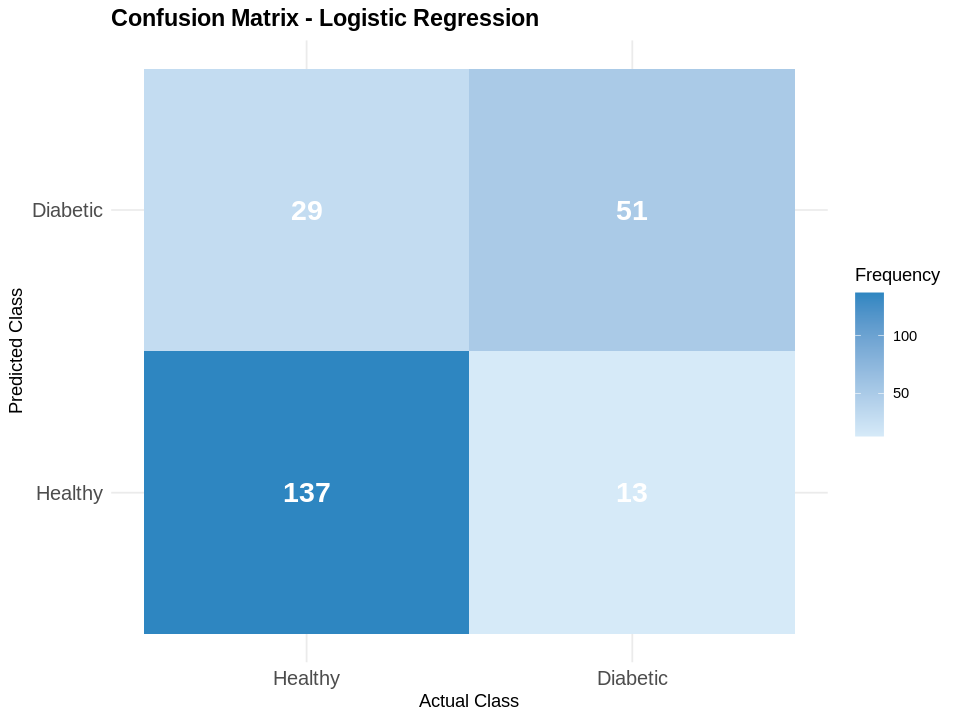

In [45]:
install.packages("pheatmap")
library(caret)
library(ggplot2)
library(pheatmap)

# Generate the confusion matrix again (if needed)
conf_mat_table <- as.data.frame(conf_matrix$table)
colnames(conf_mat_table) <- c("Reference", "Prediction", "Frequency")

# Define professional color palette
professional_colors <- scale_fill_gradient(low = "#D6EAF8", high = "#2E86C1") # Light to dark blue

# Professional Confusion Matrix Plot
ggplot(conf_mat_table, aes(x = Reference, y = Prediction, fill = Frequency)) +
  geom_tile() +
  geom_text(aes(label = Frequency), color = "white", size = 6, fontface = "bold") +
  professional_colors +
  labs(title = "Confusion Matrix - Logistic Regression",
       x = "Actual Class",
       y = "Predicted Class") +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", size = 14),
        axis.text = element_text(size = 12),
        legend.position = "right")


### Color Brewer

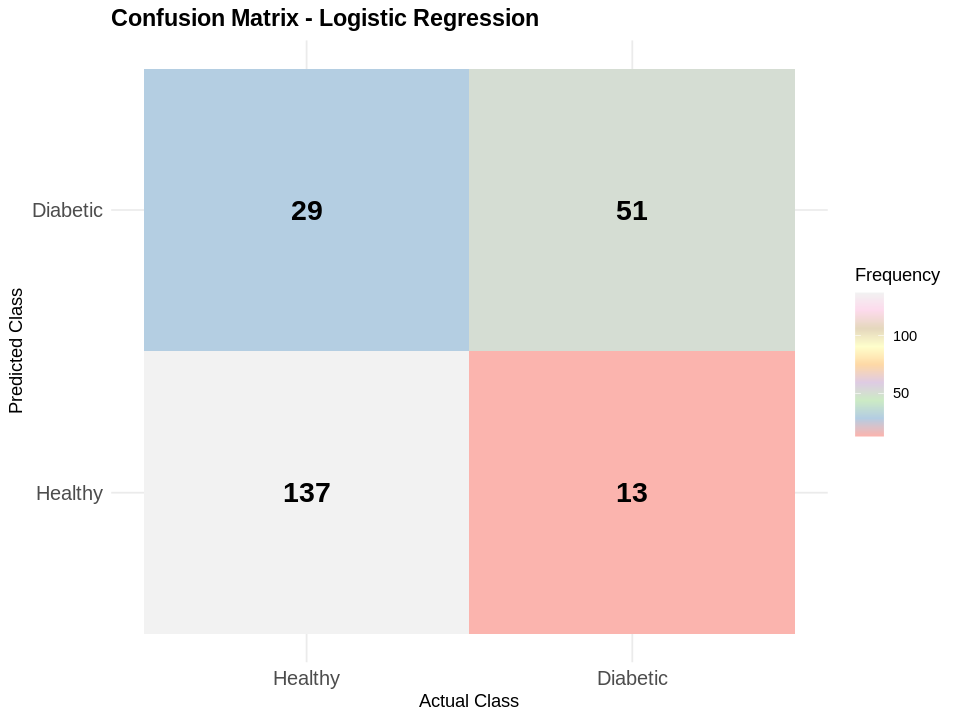

In [46]:
library(RColorBrewer)

# Define pastel colors using RColorBrewer
pastel_colors <- scale_fill_gradientn(colors = brewer.pal(9, "Pastel1"))

# Generate the confusion matrix again (if needed)
conf_mat_table <- as.data.frame(conf_matrix$table)
colnames(conf_mat_table) <- c("Reference", "Prediction", "Frequency")

# Plot Confusion Matrix with Pastel Colors
ggplot(conf_mat_table, aes(x = Reference, y = Prediction, fill = Frequency)) +
  geom_tile() +
  geom_text(aes(label = Frequency), color = "black", size = 6, fontface = "bold") + # Black text for better contrast
  pastel_colors +
  labs(title = "Confusion Matrix - Logistic Regression",
       x = "Actual Class",
       y = "Predicted Class") +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", size = 14),
        axis.text = element_text(size = 12),
        legend.position = "right")

### How good is the Model? AUC

In [47]:
library(pROC)    # For ROC curve and AUC
# Generate ROC curve data
roc_curve <- roc(testData$diabetes, pred_prob)

Setting levels: control = Healthy, case = Diabetic

Setting direction: controls < cases



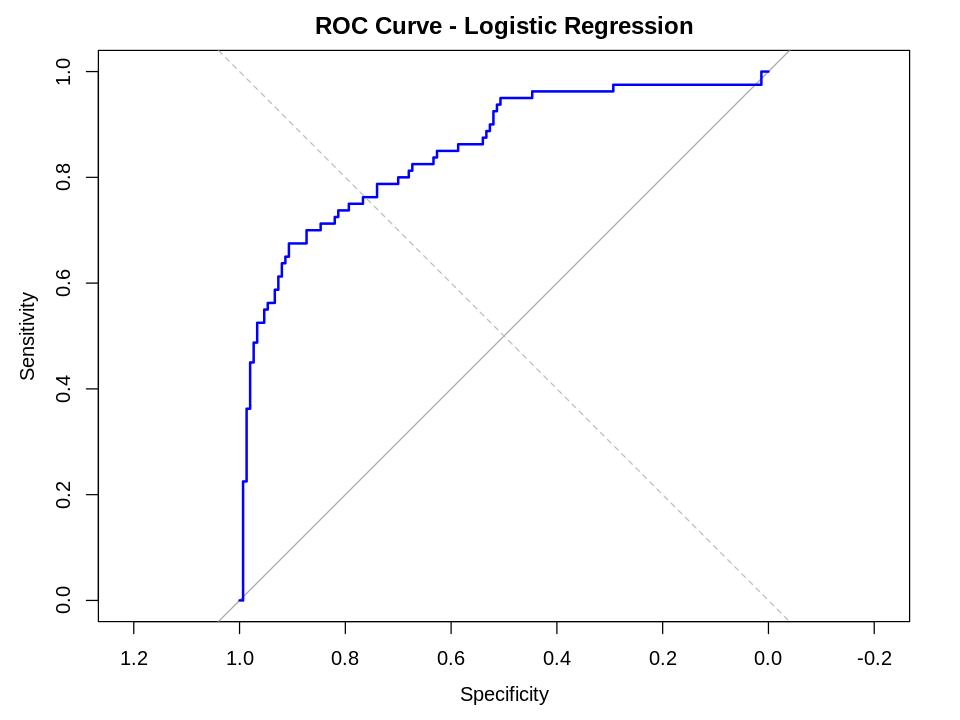

In [48]:
# Plot ROC Curve using base plot
plot(roc_curve, col = "blue", lwd = 2, main = "ROC Curve - Logistic Regression")
abline(a=0, b=1, lty=2, col="gray")  # Add diagonal reference line

In [49]:
# Display AUC (Area Under Curve) - Determines Model performance
auc_value <- auc(roc_curve)
print(paste("AUC:", round(auc_value, 3)))

[1] "AUC: 0.852"


### What is the recommended threshold for probability value?

In [50]:
# Get probability predictions
# pred_prob <- predict(logit_model, testData, type = "response")

# Define a sequence of probability thresholds
thresholds <- seq(0.1, 0.9, by = 0.05)

# Function to calculate F1 score
calculate_f1 <- function(threshold) {
  pred_class <- ifelse(pred_prob > threshold, "Diabetic", "Healthy")
  pred_class <- factor(pred_class, levels = c("Healthy", "Diabetic"))

  actual_class <- factor(testData$diabetes, levels = c("Healthy", "Diabetic"))

  conf_matrix <- confusionMatrix(pred_class, actual_class)

  precision <- conf_matrix$byClass["Precision"]
  recall <- conf_matrix$byClass["Recall"]

  f1 <- 2 * ((precision * recall) / (precision + recall))
  return(f1)
}

# Compute F1 scores for different thresholds
f1_scores <- sapply(thresholds, calculate_f1)

# Find the best threshold
best_threshold <- thresholds[which.max(f1_scores)]
best_f1 <- max(f1_scores)

# Print the best threshold and its F1-score
cat("Best Threshold:", best_threshold, "\nBest F1 Score:", best_f1, "\n")

Best Threshold: 0.65 
Best F1 Score: 0.8708709 


### Best Probability Threshold

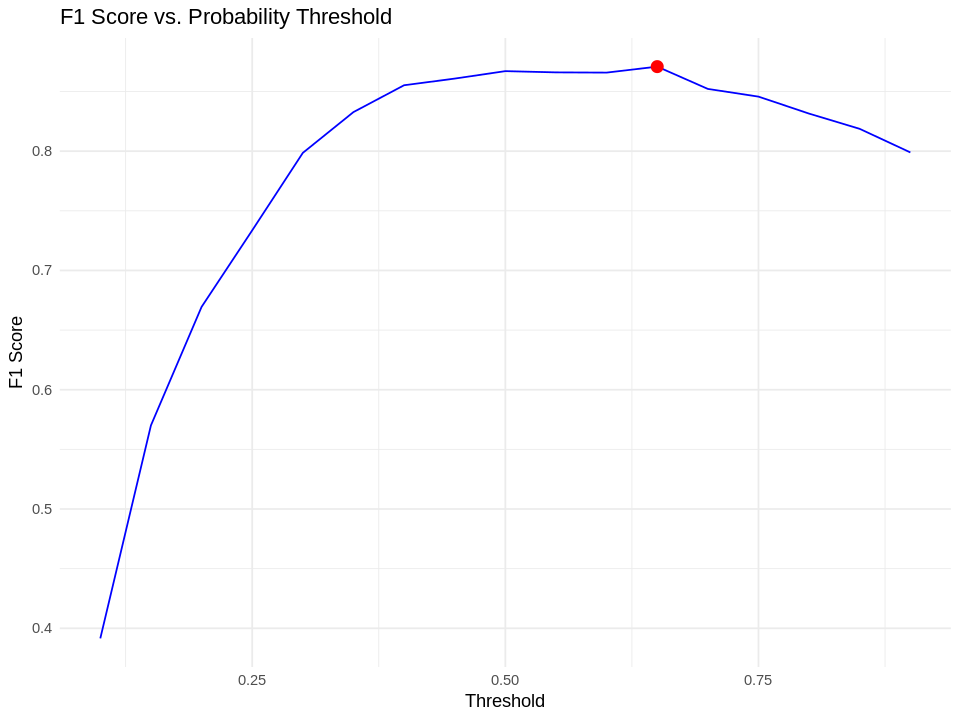

In [51]:
# Plot Threshold vs. F1 Score
f1_df <- data.frame(Threshold = thresholds, F1_Score = f1_scores)

ggplot(f1_df, aes(x = Threshold, y = F1_Score)) +
  geom_line(color = "blue") +
  geom_point(data = data.frame(Threshold = best_threshold, F1_Score = best_f1),
             aes(x = Threshold, y = F1_Score), color = "red", size = 3) +
  ggtitle("F1 Score vs. Probability Threshold") +
  xlab("Threshold") + ylab("F1 Score") +
  theme_minimal()